# Sinusoidal 
This notebook intends to demo inference in a univariate model defined as
\begin{equation}
    \begin{cases}
        Y_t = X_t + \beta W_t, \\
        \mathrm{d}X_t = \sin(X_t - \alpha) \mathrm{d}t + \sigma\mathrm{d}V_t, \\
        X_0 \sim \mathcal{N}(0, \sigma),
    \end{cases}
\end{equation}
where $\alpha, \beta, \sigma > 0$. We begin importing necessary packages for defining the model and get (using Euler-Maruyama)

In [1]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, Observable, LinearGaussianObservations

Next, we define a model where we let $(\beta, \alpha, \sigma) \triangleq (0.25, \pi, 1)$.

In [2]:
import numpy as np
from torch.distributions import Normal, Uniform, Exponential
import torch
from math import pi


def fh0(alpha, sigma):
    return torch.tensor(0.)


def gh0(alpha, sigma):
    return sigma


def fh(x, alpha, sigma):
    return torch.sin(x - alpha)


def gh(x, alpha, sigma):
    return sigma


sinus = EulerMaruyma((fh0, gh0), (fh, gh), (pi / 2, 1.), ndim=1, dt=1e-2)
simmodel = LinearGaussianObservations(sinus, 1., 0.25)

In order to perform inference, we sample some data and get

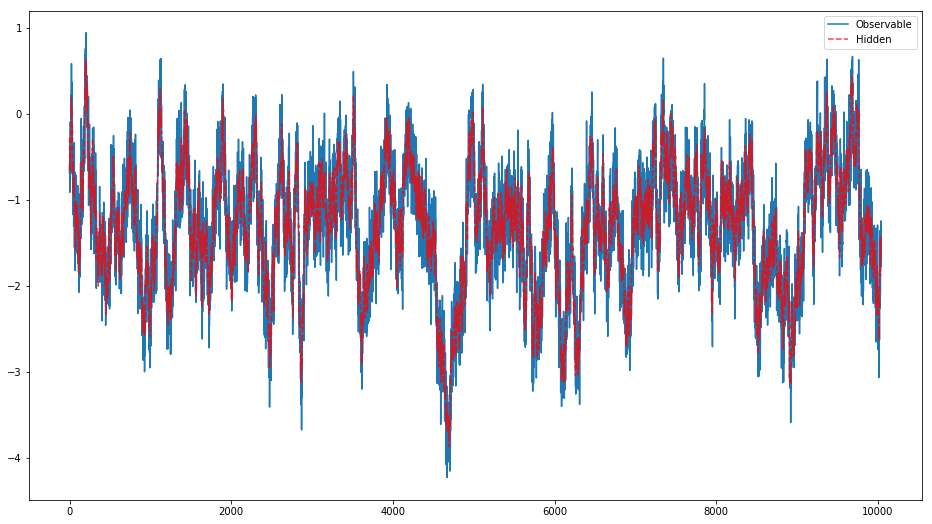

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

predictions = 40

x, y = simmodel.sample(10000 + predictions)

x = x.numpy()
y = y.numpy()

ax.plot(y, label='Observable')
ax.plot(x, 'r--', alpha=0.75, label='Hidden')

plt.legend()

We then define a model again where we set the priors to use

In [4]:
sinus = EulerMaruyma((fh0, gh0), (fh, gh), (Uniform(0., pi), Exponential(1)), ndim=1, dt=1e-2)

ssm = LinearGaussianObservations(sinus, 1., Exponential(1))

Next, we choose the inference algorithm. As the observed noise process is additive in terms of the noise, we choose the UKF to target the state, and NESS to target the parameters.

In [5]:
from pyfilter.algorithms import NESS
from pyfilter.filters import UKF
import time
import torch

algs = list()

y = torch.tensor(y)

for i in range(4):
    filt = UKF(ssm.copy())
    
    algs.append(
        NESS(filt, 1000).initialize().fit(y[:-predictions])
    )

NESS: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 152.70it/s]


We then plot the true parameters with the posteriors.

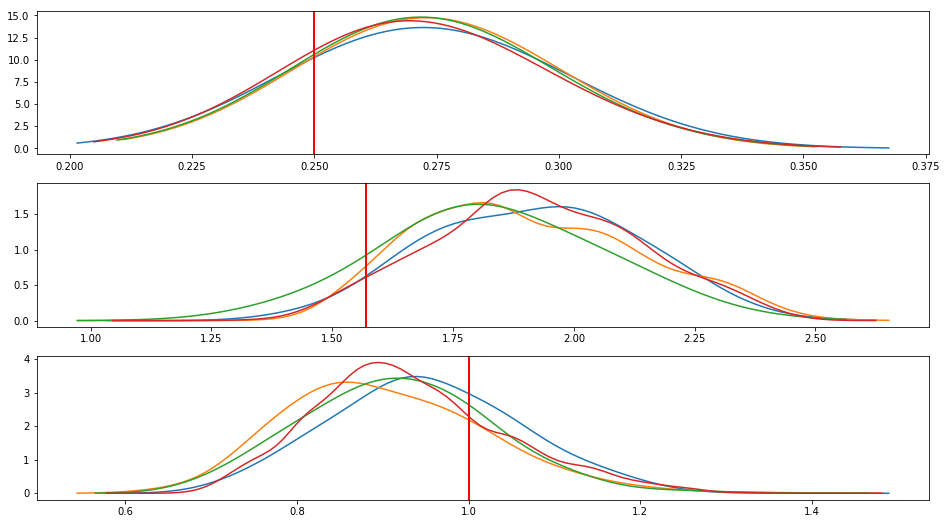

In [6]:
fig, ax = plt.subplots(3, figsize=(16, 9))

for alg in algs:
    xrange, xvals = alg.filter.ssm.observable.theta[-1].get_plottable() 
    
    ax[0].plot(xrange, xvals)
    ax[0].axvline(simmodel.observable.theta[-1].values, color='r')

    for i, (p, ptrue) in enumerate(zip(alg.filter.ssm.hidden.theta, simmodel.hidden.theta)):
        xrange, xvals = p.get_plottable()
        
        ax[i+1].plot(xrange, xvals)
        ax[i+1].axvline(ptrue.values, color='r')